In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation,ZeroPadding2D
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import UpSampling2D, Conv2D
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np
import shutil
import os
import cv2 as cv
from PIL import Image


----->RUN ONLY ONCE<------

In [ ]:
#add json file to directory

#importing dataset

# Create the .kaggle directory if it doesn't exist
os.makedirs(os.path.expanduser('~/.kaggle'), exist_ok=True)

# Move kaggle.json to the .kaggle directory
shutil.move('kaggle.json', os.path.expanduser('~/.kaggle/kaggle.json'))

# Downloading the dataset into one folder fo easier navigation
dataset_folder = 'cebra_data'
os.makedirs(dataset_folder, exist_ok=True)

!kaggle datasets download -d alsaniipe/cebradata -p {dataset_folder}


In [ ]:

# Unzip the downloaded dataset into the same folder
import zipfile
with zipfile.ZipFile(os.path.join(dataset_folder, 'cebradata.zip'), 'r') as zip_ref:
    zip_ref.extractall(dataset_folder)

# Verify dataset if it is there or not
print(os.listdir(dataset_folder))


->>>>>>>>START FROM HERE AGAIN<<<<<<-

In [4]:
#image to array function
#num_images = no of images to train with
def image_to_array(folder,target_size=(128,128)):
    #array to store images array into
    image = []
    for image_name in os.listdir(folder):
        image_path =  os.path.join(folder,image_name)

        if image_name.lower().endswith(('.jpg','jpeg','png')):
            img = Image.open(image_path).convert('RGB') #convert image to rgb>>>>>>TRY REMOVING IT LSTER
            img = img.resize(target_size)#resize the image
            img_array = np.array(img)#image to numpy array
            image.append(img_array)

    images_np_array = np.stack(image)# Stack all images into a single NumPy array
    return images_np_array

In [5]:
#converting images to np array using image_to_array
folder = r'pretty_face\face\face'
images_array = image_to_array(folder)
print(f"Final Shape Of Array: {images_array.shape}")

Final Shape Of Array: (3318, 128, 128, 3)


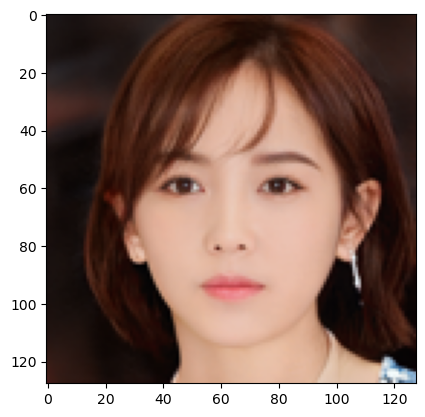

In [23]:
#checking image
plt.imshow(images_array[768])

MAKING THE ARCHITECTURE

In [24]:
# Define the Generator Model

def build_generator(latent_dim):
    model = models.Sequential()
    model.add(layers.Dense(8 * 8 * 128, input_dim=latent_dim))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Reshape((8, 8, 128)))

    model.add(layers.UpSampling2D())  # Upsample to 16x16
    model.add(layers.Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.UpSampling2D())  # Upsample to 32x32
    model.add(layers.Conv2DTranspose(128, (3, 3), padding='same'))
    model.add(layers.LeakyReLU(0.2))

    model.add(layers.UpSampling2D())  # Upsample to 64x64
    model.add(layers.Conv2DTranspose(128, (3, 3), padding='same')) 
    model.add(layers.LeakyReLU(0.2))
    
    model.add(layers.UpSampling2D())  # Upsample to 128x128
    model.add(layers.Conv2DTranspose(3, (3, 3), activation='tanh', padding='same'))  # Output: 128x128x3
    return model


In [25]:
# Define the Discriminator Model

def build_discriminator(input_shape=(128, 128, 3)):
    model = models.Sequential()

    model.add(layers.Conv2D(64, (3, 3), strides=2, input_shape=input_shape, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(128, (3, 3), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Conv2D(256, (3, 3), strides=2, padding='same'))
    model.add(layers.LeakyReLU(0.2))
    model.add(layers.Dropout(0.4))

    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model


In [26]:
#  Define the GAN Model
def build_gan(generator, discriminator):
    discriminator.trainable = False
    model = models.Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

In [27]:
# Step 4: Compile the models
latent_dim = 100
discriminator = build_discriminator()
discriminator.compile(loss='binary_crossentropy',
                    optimizer=optimizers.Adam(learning_rate=0.0001,beta_1=0.5), #lr=0.0001 instead of 0.0002 because generator loss>>>discriminator loss
                    metrics=['accuracy'])


generator = build_generator(latent_dim)
gan = build_gan(generator, discriminator)
gan.compile(loss='binary_crossentropy',
             optimizer=optimizers.Adam(learning_rate=0.0002, beta_1=0.5))


TRAINING THE GAN MODEL

In [28]:
Xtrain = (images_array.astype(np.float32)-127.5)/127.5
def train_gan(epochs=500, batch_size=32, latent_dim=100, Xtrain=Xtrain):
    half_batch = batch_size // 2
    total_batches = Xtrain.shape[0] // batch_size

    for epoch in range(epochs):
        for i in range(total_batches):
            #randomly select half_batch no of real images from the data
            rand_index = np.random.randint(0, Xtrain.shape[0], half_batch)
            real_images = Xtrain[rand_index]

            #generate fake images
            noise = np.random.normal(0, 1, (half_batch, latent_dim))
            fake_images = generator.predict(noise)

            real_loss = discriminator.train_on_batch(real_images, np.ones((half_batch, 1)))
            fake_loss = discriminator.train_on_batch(fake_images, np.zeros((half_batch, 1)))
            discriminator_loss = 0.5 * np.add(real_loss, fake_loss)

            #training gemerator
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            generator_loss = gan.train_on_batch(noise, np.ones((batch_size, 1)))
            
        
        # Print progress every epoch
        print(f"Epoch {epoch + 1}/{epochs} - Discriminator Loss: {discriminator_loss[0]} - Generator Loss: {generator_loss}")

        # Save and show generated images every epochs
        save_and_print_generated_images(epoch)
    

def save_and_print_generated_images(epoch, examples=10, figsize=(10, 2)):
    noise = np.random.normal(0, 1, (examples, latent_dim))
    generated_images = generator.predict(noise)
    generated_images = 0.5 * generated_images + 0.5  # Rescale to [0, 1] range

    fig, axs = plt.subplots(1, examples, figsize=figsize)
    for i in range(examples):
        axs[i].imshow(generated_images[i])
        axs[i].axis('off')
    plt.show()
    fig.savefig(f"gan_generated_image_{epoch}.png")
    plt.close()


1/1 [==============================] - 0s 14ms/step
Epoch 1/300 - Discriminator Loss: 0.6768851280212402 - Generator Loss: 0.6260606050491333
1/1 [==============================] - 0s 479ms/step


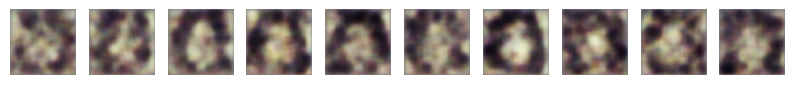

1/1 [==============================] - 0s 16ms/step
Epoch 2/300 - Discriminator Loss: 0.6558297276496887 - Generator Loss: 0.8476681709289551
1/1 [==============================] - 0s 14ms/step


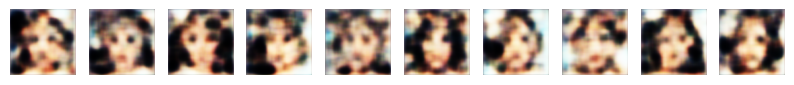

1/1 [==============================] - 0s 12ms/step
Epoch 3/300 - Discriminator Loss: 0.7195056974887848 - Generator Loss: 0.7553959488868713
1/1 [==============================] - 0s 17ms/step


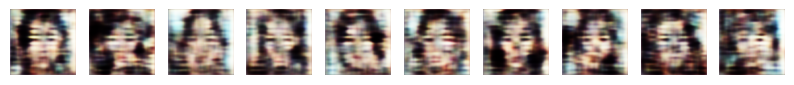

1/1 [==============================] - 0s 14ms/step
Epoch 4/300 - Discriminator Loss: 0.6732443273067474 - Generator Loss: 0.8087472915649414
1/1 [==============================] - 0s 18ms/step


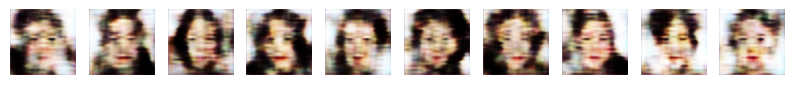

1/1 [==============================] - 0s 14ms/step
Epoch 5/300 - Discriminator Loss: 0.6385855972766876 - Generator Loss: 0.8113425374031067
1/1 [==============================] - 0s 14ms/step


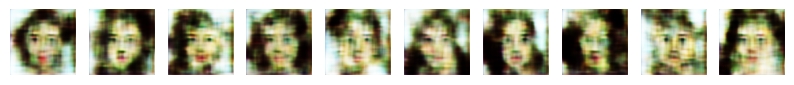

1/1 [==============================] - 0s 13ms/step
Epoch 6/300 - Discriminator Loss: 0.6707479655742645 - Generator Loss: 0.7629489898681641
1/1 [==============================] - 0s 20ms/step


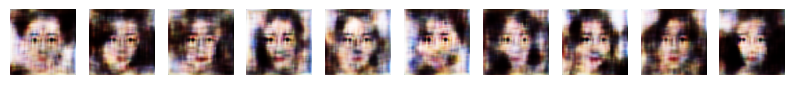

1/1 [==============================] - 0s 9ms/step
Epoch 7/300 - Discriminator Loss: 0.6864822804927826 - Generator Loss: 0.7478420734405518
1/1 [==============================] - 0s 10ms/step


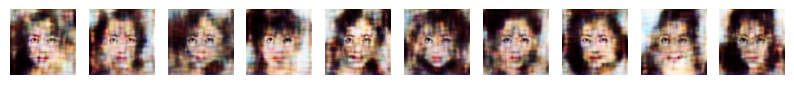

1/1 [==============================] - 0s 15ms/step
Epoch 8/300 - Discriminator Loss: 0.707524985074997 - Generator Loss: 0.7240521907806396
1/1 [==============================] - 0s 10ms/step


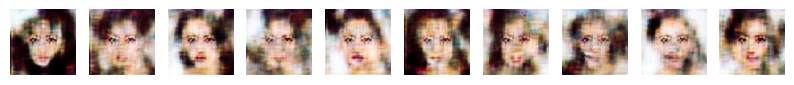

1/1 [==============================] - 0s 12ms/step
Epoch 9/300 - Discriminator Loss: 0.7007818520069122 - Generator Loss: 0.7266020774841309
1/1 [==============================] - 0s 18ms/step


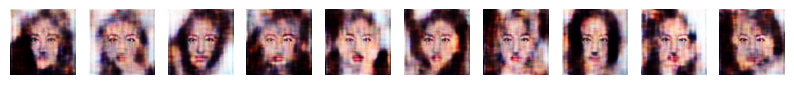

1/1 [==============================] - 0s 12ms/step
Epoch 10/300 - Discriminator Loss: 0.7024069726467133 - Generator Loss: 0.753848671913147
1/1 [==============================] - 0s 18ms/step


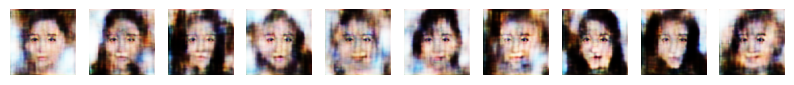

1/1 [==============================] - 0s 11ms/step
Epoch 11/300 - Discriminator Loss: 0.6875572204589844 - Generator Loss: 0.7449067831039429
1/1 [==============================] - 0s 17ms/step


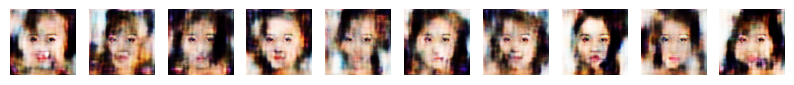

1/1 [==============================] - 0s 10ms/step
Epoch 12/300 - Discriminator Loss: 0.6938072443008423 - Generator Loss: 0.7344365119934082
1/1 [==============================] - 0s 16ms/step


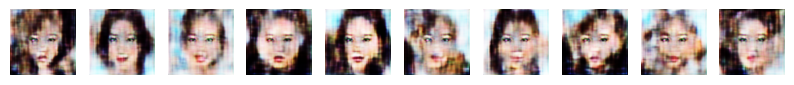

1/1 [==============================] - 0s 16ms/step
Epoch 13/300 - Discriminator Loss: 0.7016157805919647 - Generator Loss: 0.7530551552772522
1/1 [==============================] - 0s 13ms/step


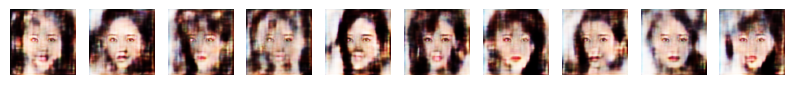

1/1 [==============================] - 0s 12ms/step
Epoch 14/300 - Discriminator Loss: 0.6841501593589783 - Generator Loss: 0.758430004119873
1/1 [==============================] - 0s 14ms/step


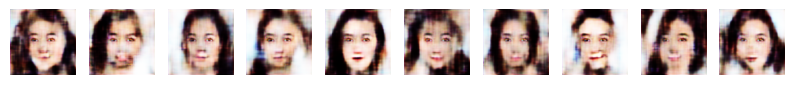

1/1 [==============================] - 0s 10ms/step
Epoch 15/300 - Discriminator Loss: 0.6773893535137177 - Generator Loss: 0.7595635652542114
1/1 [==============================] - 0s 14ms/step


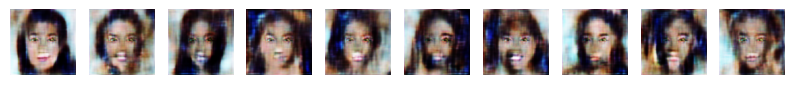

1/1 [==============================] - 0s 14ms/step
Epoch 16/300 - Discriminator Loss: 0.6833217442035675 - Generator Loss: 0.7454179525375366
1/1 [==============================] - 0s 13ms/step


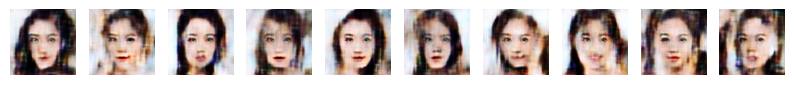

1/1 [==============================] - 0s 11ms/step
Epoch 17/300 - Discriminator Loss: 0.7038487493991852 - Generator Loss: 0.7479701042175293
1/1 [==============================] - 0s 14ms/step


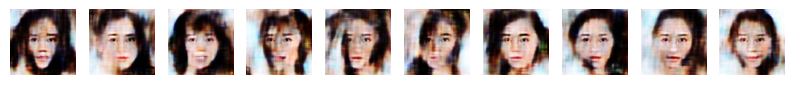

1/1 [==============================] - 0s 11ms/step
Epoch 18/300 - Discriminator Loss: 0.6985343396663666 - Generator Loss: 0.7281924486160278
1/1 [==============================] - 0s 13ms/step


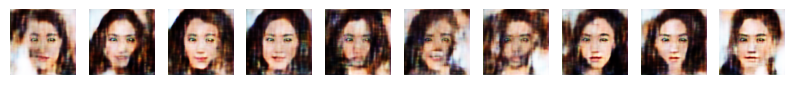

1/1 [==============================] - 0s 13ms/step
Epoch 19/300 - Discriminator Loss: 0.6907903850078583 - Generator Loss: 0.723190426826477
1/1 [==============================] - 0s 12ms/step


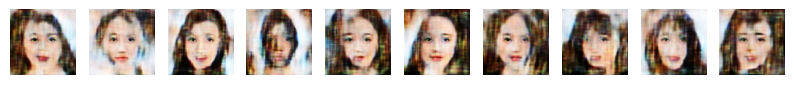

1/1 [==============================] - 0s 7ms/step
Epoch 20/300 - Discriminator Loss: 0.6815237998962402 - Generator Loss: 0.7599549293518066
1/1 [==============================] - 0s 12ms/step


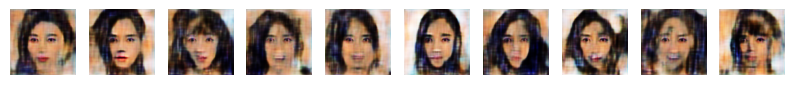

1/1 [==============================] - 0s 14ms/step
Epoch 21/300 - Discriminator Loss: 0.6924652457237244 - Generator Loss: 0.7425307035446167
1/1 [==============================] - 0s 12ms/step


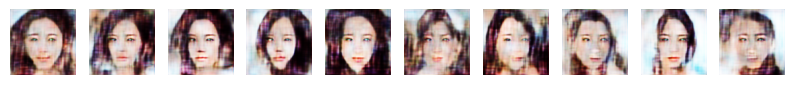

1/1 [==============================] - 0s 12ms/step
Epoch 22/300 - Discriminator Loss: 0.6894180178642273 - Generator Loss: 0.7325759530067444
1/1 [==============================] - 0s 12ms/step


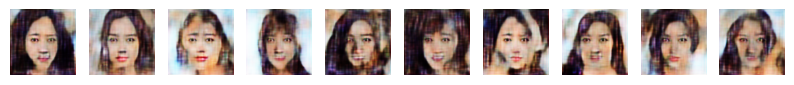

1/1 [==============================] - 0s 12ms/step


In [ ]:

# Start training the GAN
train_gan(epochs=300, batch_size=64, latent_dim=latent_dim, Xtrain=Xtrain)



In [ ]:
# Save the generator
generator.save("generator_model.h5")

# Save the discriminator
discriminator.save("discriminator_model.h5")


In [ ]:
gan.save("gan_model.h5")

1/1 [==============================] - 0s 71ms/step


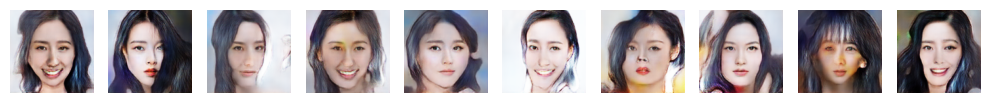

In [3]:
from tensorflow.keras.models import load_model
import numpy as np
import matplotlib.pyplot as plt

def generate_images(num_images=10, save_path='GAN_IMAGES'):
    #random latent vectors
    latent_vectors = np.random.normal(0, 1, (num_images, latent_dim))

    generated_images = generator_model.predict(latent_vectors)
    
    # Rescale images from [-1, 1] to [0, 1]
    generated_images = (generated_images + 1) / 2.0
    
    # Plot the generated images
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        plt.subplot(1, num_images, i + 1)
        plt.imshow(generated_images[i])
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    for i, img in enumerate(generated_images):
        plt.imsave(f"{save_path}/generated_image_{i + 1}.png", img)

# Example usage
latent_dim = 100  # Set the latent dimension used during training
num_images = 5    # Number of images to generate

# Load your trained generator model
generator_model = load_model(r'generator_model.h5')

# Generate and save images
generate_images(10)
